In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Paths

In [2]:
pwd

'/home/v_chernyy/thesis/notebooks'

In [3]:
import sys
sys.path.append('/home/v_chernyy/thesis')

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm

for domain in ['siemens3', 'siemens15', 'philips3', 'philips15', 'ge3', 'ge15']:

    df = pd.read_csv(f'/home/v_chernyy/CC359/{domain}/df_save.csv')

    bad_lines = []

    for line in tqdm(df.iterrows(), total=df.shape[0]):

        mask = np.asarray(Image.open(line[1]['mask']))
        if mask.sum() == 0:
            bad_lines.append(line[0])

    df = df[~df.index.isin(bad_lines)]

    print(f'{len(bad_lines) / df.shape[0] * 100:.2f}% of lines filtered')

    train_scans, val_scans = train_test_split(df.file_id.unique()[:-2])
    test_scans = df.file_id.unique()[-2::]

    df['fold'] = 'none'

    for line in tqdm(df.iterrows(), total=df.shape[0]):
        if line[1].file_id in train_scans:
            df.loc[line[0], 'fold'] = 'train'
        elif line[1].file_id in val_scans:
            df.loc[line[0], 'fold'] = 'val'
        elif line[1].file_id in test_scans:
            df.loc[line[0], 'fold'] = 'test'
        else:
            raise ValueError

    df.to_csv(f'/home/v_chernyy/thesis/dataframes/{domain}.csv')

100%|██████████| 10320/10320 [00:05<00:00, 1996.36it/s]


19.61% of lines filtered


100%|██████████| 10320/10320 [00:05<00:00, 2047.31it/s]


23.15% of lines filtered


100%|██████████| 10320/10320 [00:05<00:00, 2015.30it/s]


19.72% of lines filtered


100%|██████████| 10148/10148 [00:04<00:00, 2054.69it/s]


20.28% of lines filtered


100%|██████████| 10320/10320 [00:05<00:00, 2016.79it/s]


22.51% of lines filtered


100%|██████████| 10320/10320 [00:05<00:00, 1982.21it/s]


20.36% of lines filtered


100%|██████████| 8574/8574 [00:01<00:00, 4352.57it/s]


## Models

In [4]:
from models.seg_wrapper import LitSegNet

In [7]:
domains = ['siemens15', 'siemens3', 'ge15', 'ge3', 'philips15', 'philips3']

In [9]:
ls ../checkpoints/

ge15_segformer.ckpt  philips15_segformer.ckpt  siemens15_segformer.ckpt
ge15_unet.ckpt       philips15_unet.ckpt       siemens15_unet.ckpt
ge3_segformer.ckpt   philips3_segformer.ckpt   siemens3_segformer.ckpt
ge3_unet.ckpt        philips3_unet.ckpt        siemens3_unet.ckpt


In [13]:
models_list = [LitSegNet.load_from_checkpoint(f'../checkpoints/{d}_unet.ckpt').cpu().eval() for d in domains]
len(models_list)

/home/v_chernyy/myvenv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(


6

## Data

In [80]:
df_list[0][df_list[0]['fold'] == 'train']

,img,mask,file_id,domain,fold
1562,/raid/data/CC359/siemens15/train/CC0127_siemen...,/raid/data/CC359/siemens15/mask/CC0127_siemens...,CC0127,siemens_15,train
1563,/raid/data/CC359/siemens15/train/CC0127_siemen...,/raid/data/CC359/siemens15/mask/CC0127_siemens...,CC0127,siemens_15,train
1564,/raid/data/CC359/siemens15/train/CC0127_siemen...,/raid/data/CC359/siemens15/mask/CC0127_siemens...,CC0127,siemens_15,train
1565,/raid/data/CC359/siemens15/train/CC0127_siemen...,/raid/data/CC359/siemens15/mask/CC0127_siemens...,CC0127,siemens_15,train
1566,/raid/data/CC359/siemens15/train/CC0127_siemen...,/raid/data/CC359/siemens15/mask/CC0127_siemens...,CC0127,siemens_15,train
...,...,...,...,...,...
9958,/raid/data/CC359/siemens15/train/CC0159_siemen...,/raid/data/CC359/siemens15/mask/CC0159_siemens...,CC0159,siemens_15,train
9959,/raid/data/CC359/siemens15/train/CC0159_siemen...,/raid/data/CC359/siemens15/mask/CC0159_siemens...,CC0159,siemens_15,train
9960,/raid/data/CC359/siemens15/train/CC0159_siemen...,/raid/data/CC359/siemens15/mask/CC0159_siemens...,CC0159,siemens_15,train
9961,/raid/data/CC359/siemens15/train/CC0159_siemen...,/raid/data/CC359/siemens15/mask/CC0159_siemens...,CC0159,siemens_15,train


(60, 5)

In [119]:
import pandas as pd
from data import SegmentationDataset
from torch.utils.data import DataLoader

df_list = [pd.read_csv(f'../dataframes/{d}.csv', index_col=0) for d in domains]

# lambda df_list[0].img.split('/')[-1].split('.')[0]

dataset_list = [
    SegmentationDataset(df_list[i][(df_list[i]['fold'] == 'train') & (df_list[i]['img'].str.contains('lvl128'))], mode='test') for i, _ in enumerate(domains)
]

BATCH_SIZE=100

loader_list = [
    DataLoader(dataset_list[i], batch_size=BATCH_SIZE) for i, _ in enumerate(domains)
]

lvl128


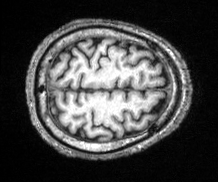

In [77]:
from PIL import Image

img_id = 256

print(df_list[0].iloc[img_id].img.split('/')[-1].split('.')[0])

Image.open(df_list[0].iloc[img_id].img)

## Method

In [120]:
import torch
import gc

torch.cuda.empty_cache(), gc.collect()

(None, 2809)

In [121]:
from sklearn.manifold import TSNE

import torch.nn as nn
import torch

import copy

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import numpy as np

from models.utils import pad_tensor, unpad_tensor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

def get_latent(model, loader, loader_id, device, to_plot=False):
    model = copy.deepcopy(model)
    model.to(device)
    
    latent_list = []
    # label_list = []

    with torch.no_grad():

        for batch in tqdm(loader, desc='batch'):

            src_img = torch.tensor(pad_tensor(batch['img'].cpu()), device=model.device)

            latent = unpad_tensor(model.forward(src_img), batch['img']).detach().cpu().flatten(start_dim=1)
            # pred_mask = (torch.sigmoid(out) > 0.5).long()

            # latent = model(batch['img'].cuda()).detach().cpu().flatten(start_dim=1)

            latent_list.append(latent)
            # label_list += [loader_id] * batch['img'].shape[0]

        # for batch in tqdm(loaderB):

        #     latent = model(batch['img'].cuda()).detach().cpu().flatten(start_dim=1)

        #     latent_list.append(latent)
        #     label_list += [1] * batch['img'].shape[0]

    latents = torch.cat(latent_list, 0)
    # labels = np.array(label_list)
    
    latent_embedded = TSNE(n_components=2).fit_transform(latents)

    if to_plot:
        plt.figure(figsize = (7, 5))

        plt.scatter(latent_embedded[:, 0], latent_embedded[:, 1], alpha=0.2)
        plt.axis('off')

        plt.show()
    
    return latent_embedded#, labels

cuda:0


In [ ]:
get_latent(models_list[0], loader_list[0], loader_id=0, device=DEVICE, plot)

In [126]:
latent_list = [get_latent(models_list[0], loader, loader_id=i, device=DEVICE) for i, loader in enumerate(loader_list)]

# latent_2, _ = get_latent(models_list[1].model, testA_loader, testB_loader, DEVICE, to_plot=False)

# latent_3, _ = get_latent(models_list[2].model, testA_loader, testB_loader, DEVICE, to_plot=False)

batch:   0%|          | 0/1 [00:00<?, ?it/s]

batch:   0%|          | 0/1 [00:00<?, ?it/s]

batch:   0%|          | 0/1 [00:00<?, ?it/s]

batch:   0%|          | 0/1 [00:00<?, ?it/s]

batch:   0%|          | 0/1 [00:00<?, ?it/s]

batch:   0%|          | 0/1 [00:00<?, ?it/s]

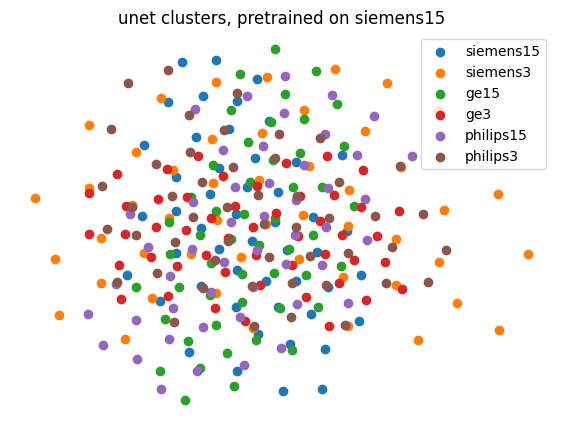

In [129]:
plt.figure(figsize = (7, 5))
plt.title(f'unet clusters, pretrained on {domains[0]}')

for latent, domain in zip(latent_list, domains):

    plt.scatter(latent[:, 0], latent[:, 1], alpha=1, label=domain)

plt.legend()
plt.axis('off')
plt.show()